# Chapter 7: k-Nearest Neighbors (k-NN)


> (c) 2019-2020 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.
>
> Date: 2020-03-08
>
> Python Version: 3.8.2
> Jupyter Notebook Version: 5.6.1
>
> Packages:
>   - pandas: 1.0.1
>   - scikit-learn: 0.22.2
>
> The assistance from Mr. Kuber Deokar and Ms. Anuja Kulkarni in preparing these solutions is gratefully acknowledged.


In [227]:
# Import required packages for this chapter
from pathlib import Path
import math

import pandas as pd
import numpy as np
from sklearn.metrics import pairwise
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor #, NearestNeighbors
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Problem 7.2 Personal Loan Acceptance

Universal Bank is a relatively young bank growing rapidly in terms of overall customer acquisition. The majority of these customers are liability customers (depositors) with varying sizes of relationship with the bank. The customer base of asset customers (borrowers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business. In particular, it wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise smarter campaigns with better target marketing. The goal is to use
k-NN to predict whether a new customer will accept a loan offer. This will serve as the basis for the design of a new campaign.

The file _UniversalBank.csv_ contains data on 5000 customers. The data include customer demographic information (age, income, etc.), the customer’s relationship with the bank (mortgage, securities account, etc.), and the customer response to the last personal loan campaign (Personal Loan). Among these 5000 customers, only 480 (= 9.6%) accepted the personal loan that was offered to them in the earlier campaign.

Partition the data into training (60%) and validation (40%) sets.

__7.2.a__ Consider the following customer:

Age = 40, Experience = 10, Income = 84, Family = 2, CCAvg = 2, Education_1= 0, Education_2 = 1, Education_3 = 0, Mortgage = 0, Securities Account = 0, CD Account = 0, Online = 1, and Credit Card = 1. Perform a k-NN classification with all predictors except ID and ZIP code using k = 1. Remember to transform categorical predictors with more than two categories into dummy variables first. Specify the success class as 1 (loan acceptance), and use the default cutoff value of 0.5. How would this customer be classified?

__Answer:__ 

#### Data preparation
Load the data and remove unnecessary columns (ID, ZIP Code). Split the data into training (60%) and validation (40%) sets (use `random_state=1`).

In [256]:
# Load the data
# Missing 1 line of code
bank_df = pd.read_csv('Ch-07-UniversalBank.csv')
# Drop ID and zip code columns
# Missing 1 line of code
bank_df = bank_df.drop(['ID', 'ZIP Code'], axis = 1)
# Make sure that the result is as expected
#Missing 1 line of code
bank_df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


In [257]:
# modify column names by replacing the " " (spaces) with "_" (underscores)
#Missing 1 line of code
bank_df.columns = bank_df.columns.str.replace(' ','_')
list(bank_df.columns)

['Age',
 'Experience',
 'Income',
 'Family',
 'CCAvg',
 'Education',
 'Mortgage',
 'Personal_Loan',
 'Securities_Account',
 'CD_Account',
 'Online',
 'CreditCard']

In [258]:
# create dummy variables for categorical variable, we consider Education as categorical variable

#Change the datatype of the column Education to be .astype('category')
#Missing 1 line of code
bank_df['Education'] = bank_df['Education'].astype('category')
#convert any categorial or string columns to be dummy varialbes keeping the name of the dataframe as bank_df
#Missing 1 line of code (hint: get_dummies())
bank_df = pd.get_dummies(bank_df)
bank_df.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3
0,25,1,49,4,1.6,0,0,1,0,0,0,1,0,0
1,45,19,34,3,1.5,0,0,1,0,0,0,1,0,0
2,39,15,11,1,1.0,0,0,0,0,0,0,1,0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,0,1,0
4,35,8,45,4,1.0,0,0,0,0,0,1,0,1,0


In [259]:
# split dataset into training (60%) and validation (40%) sets
#Missing 1 line of code

train_df, valid_df = bank_df[0:int(bank_df.shape[0]*0.6)],  bank_df[int(bank_df.shape[0]*0.6):]
print('Training set:', train_df.shape, 'Validation set:', valid_df.shape)

Training set: (3000, 14) Validation set: (2000, 14)


In [260]:
# new customer
newCustomer = pd.DataFrame([
                            {'Age': 40, 
                             'Experience': 10, 
                             'Income': 84, 
                             'Family': 2, 
                             'CCAvg': 2, 
                             'Mortgage': 0,
                             'Securities_Account': 0, 
                             'CD_Account': 0, 
                             'Online': 1, 
                             'CreditCard': 1, 
                             'Education_1': 0, 
                             'Education_2': 1, 
                             'Education_3': 0
                            }],
                            columns=['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage', 'Securities_Account',
                                   'CD_Account', 'Online', 'CreditCard', 'Education_1', 'Education_2', 'Education_3'])
newCustomer

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3
0,40,10,84,2,2,0,0,0,1,1,0,1,0


In [261]:
#Create a variable called outcome to have the value of the column name we are predicting
#Missing 1 line of code
outcome = bank_df['Personal_Loan']
#Create a list called predictors containing the names of the the predictor columns we are using
#Missing 1 or 2 lines of code depending on how you want to do this step
predictors = ['Age','Experience','Income','Family','CCAvg','Mortgage','Securities_Account','CD_Account','Online','CreditCard','Education_1','Education_2','Education_3']
#PREDICTORS = bank_df[predictors]

In [262]:
# normalize training and validation sets. The transformation is trained using the training set only.
# if you don't convert the integer columns to real numbers (float64), the StandardScaler will raise a DataConversionWarning. This is expected

# Create an object called scaler so that twe can use it to standardize the data
#Missing 1 line of code
scaler = StandardScaler()

#Fit the scaler object to the predictor data
#Missing 1 line of code
scaler.fit(bank_df[predictors])

# Transform the PREDICTORS of training, validation and newCustomer
#Leave the outcome variable untouched.  Call the datasets train_X, train_y, valid_X, and valid_y as we have done
# in our examples
#Missing 4 lines of code

train_df = scaler.transform(train_df[predictors])
valid_df = scaler.transform(valid_df[predictors])
#newCustomer = scaler.transform(newCustomer[predictors])
train_X, train_y = train_df,  outcome[:int(bank_df.shape[0]*0.6)]
valid_X, valid_y = valid_df,  outcome[:int(bank_df.shape[0]*0.4)]

In [263]:

newCustomerNorm = pd.DataFrame(scaler.transform(newCustomer), 
                               columns=['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage', 'Securities_Account',
                                   'CD_Account', 'Online', 'CreditCard', 'Education_1', 'Education_2', 'Education_3'])
newCustomerNorm

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3
0,-0.465747,-0.881204,0.222159,-0.345432,0.035515,-0.555524,-0.341423,-0.25354,0.821951,1.549632,-0.849566,1.601185,-0.654965


In [264]:
# Create k-NN model using using k = 1  Call the model knn.
# Make sure to use the Classifier version since we are classifiying and not the Regressor used for numerical prediction
#Fit the new data to the validation predictors and training data
#Missing 1 to 2 lines of code depending on how you want to to do this (HINT: synchronous exampe Table 7.3 line 16)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_X, train_y)

KNeighborsClassifier(n_neighbors=1)

In [265]:
# Use the new modle to predict the new data newCustomerNorm
#Missing 1 line of code

knn.predict(newCustomerNorm)

array([0], dtype=int64)

In [266]:
# compute the predicted probability
knn.predict_proba(newCustomerNorm)

array([[1., 0.]])

New customer is predicted to not accept a loan offer.

__7.2.b__ What is a choice of k that balances between overfitting and ignoring the predictor information?

__Answer__

In [267]:
# Train a classifier for different values of k
# Let's try from 1 to 19 on our K value and see which one worked best
# HINT: Use loop logic from Table 7.3 from the synchronous KNN session
#MISSING 6-7 lines of code (depending on how closely you follow the example from class)
results= []
for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i).fit(train_X, train_y)
    preds = knn.predict(valid_X)
    score = accuracy_score(preds, valid_y)
    results.append((i, score))

# Convert results to a pandas data frame
results = pd.DataFrame(results, columns = ['k', 'accuracy'])
results

,k,accuracy
0,1,0.8505
1,2,0.8680
2,3,0.8615
3,4,0.8670
4,5,0.8640
5,6,0.8690
6,7,0.8635
7,8,0.8720
8,9,0.8670
9,10,0.8740


<AxesSubplot:xlabel='k', ylabel='accuracy'>

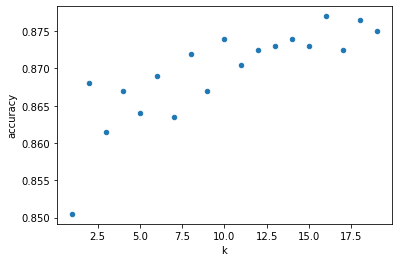

In [268]:
# plot accuracy vs. k
#MISSING 1 line of code

results.plot.scatter(x = 'k', y = 'accuracy')


<b>Answer:</b>
We choose the best k, which minimizes the misclassification rate in the validation set. Our best k is <b>??????</b>

__7.2.c.__ Show the confusion matrix for the validation data that results from using the best k.

__Answer__ 

In [269]:
# Now that we know the best number of K to use ...
# Rerun the model with the n_neighbors hard coded to the value of K that we found to be best.

#MISSING  1 line of code (Hint: Table 7.4 from synchrnous)
knn = KNeighborsClassifier(n_neighbors=16).fit(train_X, train_y)

#Run the best model above on the validation data
knnPredOpt = knn.predict(valid_X)

#Print out the confusion Matrix
print(confusion_matrix(valid_y, knnPredOpt))
print('Accuracy :', accuracy_score(valid_y, knnPredOpt))

[[1742   58]
 [ 188   12]]
Accuracy : 0.877


__7.2.d.__ Consider the following customer: Age = 40, Experience = 10, Income = 84, Family = 2, CCAvg = 2, Education_1 = 0, Education_2 = 1, Education_3 = 0, Mortgage = 0, Securities Account = 0, CD Account = 0, Online = 1 and Credit Card = 1. Classify the customer using the best k.

In [270]:
# Predict above customer class
#MISSING 1 line of code
knn.predict(newCustomerNorm)

array([0], dtype=int64)

In [271]:
# predicted probability (Hint: answer given in an earlier cell above)
#MISSING 1 line of code

knn.predict_proba(newCustomerNorm)

array([[1., 0.]])

<b>Answer</b>
The new customer is predicted to <b>class 0</b>

__Answer__
Did the answer change from when we used only 1 K in the beginning of the assignment?

Yes the answer changed from 1 to 0